# 22 - Debiased/Orthogonal Machine Learning
 
The next meta-learner we will consider actually came before they were even called meta-learners. 

As far as I can tell, it came from an awesome 2016 paper that sprung a fruitful field in the causal inference literature. The paper was called [__Double Machine Learning for Treatment and Causal Parameters__](https://arxiv.org/pdf/1608.00060.pdf) and it took a lot of people to write it: Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo (which, by the way, won the 2020 Economics Nobel Prize along with Abhijit Banerjee and Michael Kremer "for their experimental approach to alleviating global poverty"), Christian Hansen, Whitney Newey and James Robins. No wonder it was a very good paper and I even took the liberty of representing its authors as the Avengers just because (credits to Paul Goldsmith-Pinkham who had this idea first). 
 
![img](./data/img/debiased-ml/avengers.png)
 
There is only one problem with the paper: it is incredibly difficult to read (which is expected, since it's an econometric paper). And since this book is all about making causal inference mainstream, here we are, trying to make Debiased/Orthogonal Machine Learning intuitive. 
 
But what makes it so special as to deserve it's own chapter, apart from the other meta-learners? 
- The thing that caught my attention was how well justified this `Debiased/Orthogonal ML` is. 
- The other methods that we've seen so far, the T-learner, S-Learner and X-learner, all seem a bit hackish. We can give an intuitive explanation about why they work, but they didn't seem very general. 
- In contrast, with Debiased/Orthogonal Machine Learning, we have a __general framework__ we can apply, which is both very intuitive and also very rigorous. 
- Another bonus is that Debiased/Orthogonal ML works for both `continuous` and `discrete` treatments, something that neither the T, not X learner could do. 
- Not to mention that the papers describing it do an incredible job with the asymptotic analysis of this estimator. 

So without further ado, let's get down to it.  
 
Once again, as a motivating example, we will resort to our ice cream sales dataset. Just as a reminder, here we are trying to __find heterogeneity on the effect of price on sales__. Our test set has randomly assigned prices but our training data has only observational prices, which is potentially biased. 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [3]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head(10)

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227
5,26.1,6,0.5,6.6,193
6,25.0,6,0.3,4.9,191
7,18.5,5,0.5,3.9,189
8,30.1,3,1.0,6.5,208
9,19.8,5,0.3,5.4,167


/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='price', ylabel='sales'>

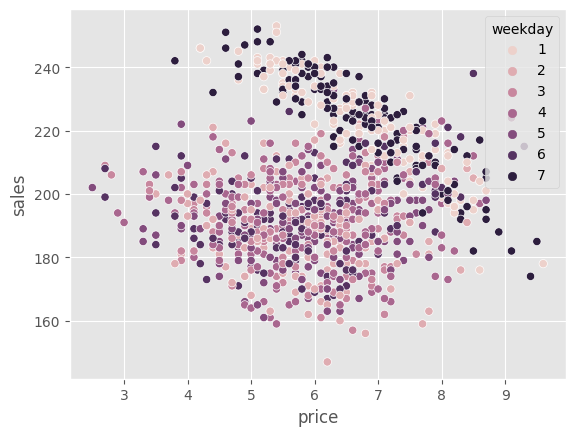

In [4]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

One source of bias is very clear. As we can see, prices are much higher on the weekend (weekdays 1 and 7), but we can also have other confounders, like temperature and cost. So, if we want to do any causal inference with it, we will need to correct this bias. 

## ML for Nuisance Parameters
 
One way we can try to remove this bias is by using a linear model to estimate the treatment effect of prices on sales while controlling for the confounders. 
 
$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 cost_i + \pmb{\beta_3} Weekday_i + e_i
$$
 
where $\pmb{\beta_3}$ is a vector of parameters associated with each weekday dummy. 
 
Notice that we are only interested in the $\tau$ parameter because that's our treatment effect. We are going to call the other parameters `nuisance parameters` because we don't care about them. 

But, as it turns out, even if we don't care about them, we have to get them right, because if we don't, our treatment effect will be off. That's sort of annoying. 
 
For instance, if we think about it, the relationship between `temp` and sales is probably __not linear__. First, as temperature increases, more people will go to the beach and buy ice cream, so sales will increase. But, at some point, it becomes too hot and people decide it is best to stay home. At that point, sales will drop. The relationship between `temp` and sales probably peaks somewhere and then decreases. Which means the above model is probably wrong. It should have been something like
 
$$
Sales_i = \alpha + \tau price_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 cost_i + \pmb{\beta_4} Weekday_i + e_i
$$
 
with a quadratic term.
 
![img](./data/img/debiased-ml/non-linear.png)


Thinking about how to model nuisance parameters is already boring with just a few covariates. But what if we had __tens or hundreds of them__? With modern datasets, this is pretty common. 

So, what can we do about it? The answer lies the coolest Econometric theorem ever derived.

### Frisch-Waugh-Lovell (FWL)
 
Frisch, Waugh and Lovell were 20th century econometricians who noticed the coolest thing about linear regression. This isn't new to you, as we've talked about it in the context of regression residuals and when talking about fixed effects. But since this theorem is key to understanding Orthogonal-ML, it's very much worth recapping it.
 
Suppose you have a linear regression model with a set of features $X_1$ and another set of features $X_2$. You then estimate that model's parameters.
 
$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$
 
where $X_1$ and $X_2$ are feature matrices (one column per feature and one row per observation) and $\hat{\beta_1}$ and $\hat{\beta_2}$ are row vectors. 

You can get the __exact same $\hat{\beta_1}$ parameter__ by doing the following steps
 
1. regress the outcome $y$ on the second set of features $\hat{y^*} = \hat{\gamma_1} X_2$
2. regress the first set of features on the second $\hat{X_1} = \hat{\gamma_2} X_2$
3. obtain the residuals $\tilde{X}_1 = X_1 - \hat{X_1}$ and $\tilde{y}_1 = y - \hat{y^*}$
4. regress the residuals of the outcome on the residuals of the features $\tilde{y} = \hat{\beta_1} \tilde{X}_1$
 
This is insanely cool. Here, we have a generic representation, but notice that one set of features can be just the treatment variable. This means you can estimate all the nuisance parameters separately. 
1. Regress the outcome on the features to get outcome residuals.
2. Regress the treatment on the features to get treatment residuals.
3. Regress the outcome residuals on the feature residuals. 

__This will yield the exact same estimate as if we regress the outcome on the features and treatment at the same time__.
 
But don't take my word for it. FWL is something that everyone interested in causal inference should do at least once. In the example below, we estimate the treatment effect by first estimating the effects of the covariates on the outcome (sales) and treatment (price).

In [11]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

Then, with the residuals, we estimate the ATE of price on sales.

In [12]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.231e-13,0.111,-2.02e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


We've estimated the ATE to -4, meaning that each unit increase in price will lower sales by 4 units.
 
Now, let's estimate the same parameter, but this time, we will include the treatment and the covariates in the same model.

In [13]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475503

As you can see, they are the exact same number! __This shows that estimating the treatment effect all at once or separating in the FWL steps is mathematically the same__.
 
Another way of saying this is that the treatment effect can be derived from **regression on residuals**, where we obtain the residuals from regressing $Y$ on $X$, and regress it on the residuals of regressing $T$ on $X$. 

Let's say that $\sim$ is the regression operator, so we can summarise FWL theorem as follows. 
 
$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$
 
which is essentially estimating the causal parameter $\tau$ in the following model
 
$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$
 
As I've said, FWL is so awesome because it allows us to __separate the estimation procedure of the causal parameter from that of the nuisance parameters__. 

But we still didn't answer our initial question, which is how can we avoid all the hassle from having to specify the correct functional form on the nuisance parameters? Or, in other words, how can we focus only on the causal parameter without having to worry about the nuisance parameters? Here is where machine learning comes to play.

![img](./data/img/debiased-ml/drown-ols.png)

### Frisch-Waugh-Lovell on Steroids

Double/Debiased ML can be seen as Frisch, Waugh and Lovell theorem on steroids. The idea is very simple: use ML models when constructing the outcome and treatment residuals: 
 
$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$
 
Where $\hat{M}_y(X_i)$ is estimating $E[Y|X]$ and  $\hat{M}_t(X_i)$ is estimating  $E[T|X]$.
 
The idea is that `ML models` are super flexible, hence, they can __capture interactions and non linearities__ when estimating the $Y$ and $T$ residuals while still maintaining a FWL style orthogonalisation.

This means we don't have to make any __parametric assumption__ about the relationship between the covariates $X$ and the outcome $Y$, nor between the covariates and the treatment in order to get the correct treatment effect. 

Provided we don't have unobserved confounders, we can recover the ATE with the following orthogonalisation procedure:
 
1. Estimate the outcome $Y$ with features $X$ using a flexible ML regression model $M_y$. 
2. Estimate the treatment $T$ with features $X$ using a flexible ML regression model $M_t$. 
3. Obtain the residuals $\tilde{Y} = Y - M_y(X)$ and $\tilde{T} = T - M_t(X)$
4. regress the residuals of the outcome on the residuals of the treatment $\tilde{Y} = \alpha + \tau \tilde{T}$
 
where $\tau$ is the causal parameter ATE, which we can estimate, for example, with OLS. 
 
The power you gain with ML is `flexibility`. ML is so powerful that it can capture complicated functional forms in the nuisance relationships. 

But that flexibility is also troublesome, because it means we now have to take into account the possibility of `overfitting`.
 
![img](./data/img/debiased-ml/ml-problem.png)

Chernozhukov et al (2016) has a much more in depth and rigorous explanation about how overfitting can be troublesome and I definitely recommend you check it out. But here, I'll go on with a more intuition based explanation. 
 
To see the issue, suppose that your $M_y$ model is overfitting. The result is that the residual $\tilde{Y}$ will be smaller than it should be. It also means that $M_y$ is capturing more than only the relationship between $X$ and $Y$. Part of that something more is the relationship between $T$ and $Y$, and if $M_y$ is capturing some of that, the residual regression will be __biased towards zero__. In other words, $M_y$ is capturing the causal relationship and not leaving it to the final residual regression. 
 
Now to see the problem in overfitting $M_t$, notice that it will explain more of the variance in $T$ than it should. As a result, the treatment residual will have less variance than it should. If there is less variance in the treatment, the variance of the final estimator will be high. It is as if the treatment is the same for almost everyone. And if everyone has the same treatment level, it becomes very difficult to estimate what would happen under different treatment levels. As a side note, this will also happen when $T$ is a deterministic function of $X$, meaning positivity is being violated.
 
Those are the problems we have when using ML models, but how can we correct them? The answer lies in what we will call cross prediction and `out-of-fold` residuals. 
 
![img](./data/img/debiased-ml/cross-prediction.png)
 
We will split out data into K parts of equal size. Then, for each part k, we will estimate the ML models on all the other K-1 samples and make the residuals on the k part. 

Notice that these residuals are made using `out-of-fold` prediction. We fit the model on one part of the data, but make the predictions and residuals on another part. 
 
so even if the model does overfit, it won't drive the residuals to zero artificially. Finally, we combine the predictions on all the K parts to estimate the final causal model $\tilde{Y} = \alpha + \tau \tilde{T}$.
 
OK, we've covered a lot of ground and it might be getting hard to keep up without an example. To go along with all that theory, let's go through a step by step implementation of the Double/Debiased ML. As we do so, I'll take the opportunity to explain what each step is doing. 
 
First, let's estimate the nuisance relationship using ML models. I'll start with the treatment model $M_t$. We will use a LGBM model to predict prices from the covariates `temp`, `weekday` and `cost`. These predictions will be cross predictions, which we can get from using `sklearn`'s `cross_val_predict` function. I'm also adding the average $\hat{\mu_t}$ to the residuals just for visualization purposes.

In [14]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Notice that I'm calling the $M_t$ model the `debias model`. 
- That's because the role this model is playing on the Double/Debias ML is one of debiasing the treatment. 
- The residuals $\tilde{T} = T - M_t(X)$ can be viewed as a version of the treatment where all the confounding bias from $X$ has been removed by the model. 
- In other words, $\tilde{T}$ is orthogonal to $X$. 
- Intuitively, $\tilde{T}$ can no longer be explained by $X$, because it already was. 
 
To see that, we can show the same plot we've seen earlier but now replacing price with the price residuals. Remember that, before, weekends had higher prices? Now, that bias is gone. All the weekdays have the same price residual distribution. 

/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


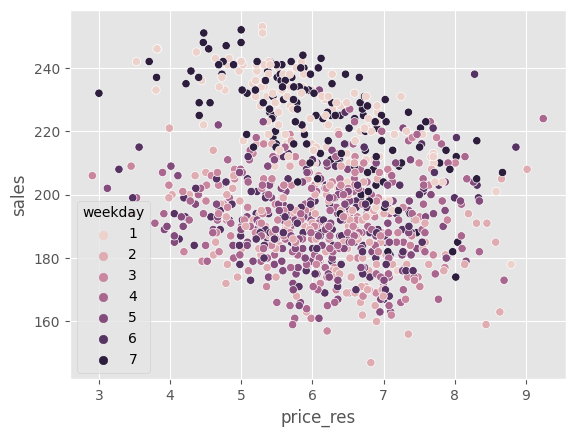

In [15]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

The role of $M_t$ is to debias the treatment, but what about $M_y$? Its role is to remove the `variance` from $Y$. Hence, I'll call it the `denoising model`. 
- Intuitively, $M_y$ is creating a version of the outcome where all the variance due to $X$ has been explained away. 
- As a result, it becomes easier to do causal estimation in $\tilde{Y}$. 
- Since it has less noise, the causal relationship becomes easier to see. 

In [16]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

If we plot the same graph as before, but now replacing sales with sales residual, we can see that the variance in $Y$ is much smaller than it was before. 

/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yongchaohao/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


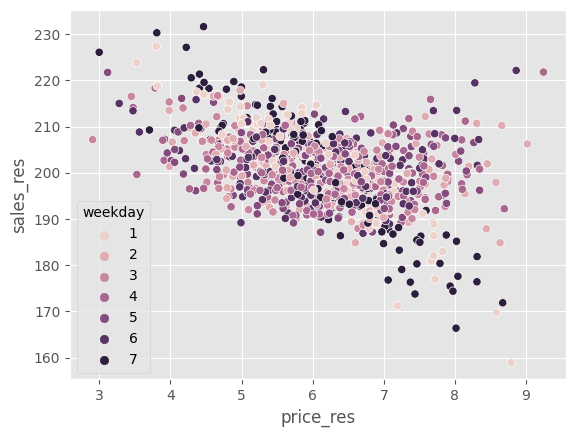

In [12]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

It is now easy to see the __negative relationship__ between prices and sales. 
 
Finally, to estimate that causal relationship, we can run a regression on the residuals.

In [17]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


As we can see, when we use the residualized or orthogonalised version of sales and price, we can be very confident that the relationship between prices and sales is negative, which makes a lot of sense. As we increase prices, demand for ice cream should fall.
 
But if we look at the un-residualized or raw relationship between prices and sales, because of bias, we find a positive relationship. That is because, in anticipation to high sales, prices are increased. 

In [18]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


### CATE Estimation with Double-ML
 
So far, we've seen how Double/Debiased ML allow us to focus on estimating the `Average Treatment Effect (ATE)`.

But it can also be used to estimate treatment effect heterogeneity or `Conditional Average Treatment Effect (CATE)`. Essentially, we are now saying that the causal parameter $\tau$ changes depending on the unit's covariates. 
 
$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$
 
To estimate this model, we will use the same residualised version of price and sales, but now we will __interact the price residuals with the other covariates__. Then, we can fit a linear CATE model.
 
$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$
 
Once we've estimated such a model, to make CATE predictions, we will use the randomised test set. 

Since this final model is linear, we can compute the CATE mechanically:
 
$
\hat{\mu}(\partial Sales_i, X_i) = M(Price=1, X_i) - M(Price=0, X_i)
$

where $M$ is our final linear model

In [19]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

In [17]:
cate_test.head(10)

,temp,weekday,cost,price,sales,cate
0,25.8,1,0.3,7,230,-11.236856
1,22.7,3,0.5,4,190,-1.662280
2,33.7,7,1.0,5,237,-10.013794
3,23.0,4,0.5,5,193,-1.742061
4,24.4,1,1.0,3,252,-10.512542
5,30.3,7,0.5,9,191,-10.841789
6,20.4,1,1.0,7,222,-10.794931
7,21.6,6,1.0,8,188,-0.984253
8,24.8,6,0.5,8,192,-1.346306
9,22.7,3,0.5,6,189,-1.662280


To check how good this model is in terms of differentiating units with high price sensitivity from those with low price sensitivity, we will use the cumulative elasticity curve. 

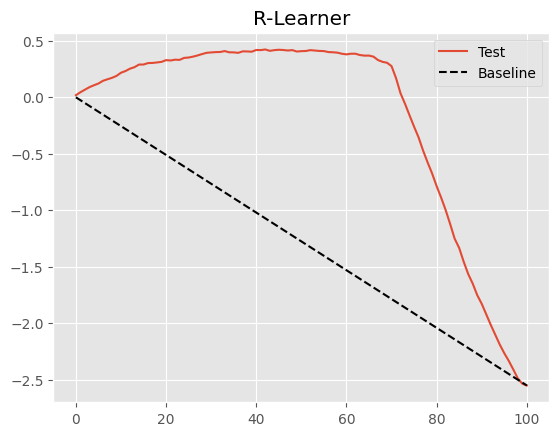

In [20]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

The Double/Debiased ML procedure with a final linear model is already very good, as we can see by the curve above. But, maybe we can do even better. As a matter of fact, this is a very general procedure that we can understand just like a meta-learner. Nie and Wager called it the `R-Learner`, as a way to recognise the work of Robinson (1988) and to emphasize the role of residualization.
 
This generalization comes from realizing that the Double/Debiased ML procedure defines a __new loss function__ that we can minimize however we want. 

Next, we will see how to do that in a very similar fashion to what we've seen before when discussing `target transformation` method or `F-learner`. 


## Non Parametric Double/Debiased ML
 
The nice thing about Double-ML is that it frees us from all the hassle of learning the nuisance parameters in a causal model. With that, we can focus all our attention to learning the causal parameter of interest, be it the ATE or the CATE. 

However, with the above specification, we were still using a linear model after the ML residualization, as the final causal model. In our example, this means we are __assuming that price impacts sales linearly__. 
- That's probably OK for a small range of prices, but we know from microeconomic theory that that's not necessarily the case. 
- It could be that, at low prices, a unit increase in price will lower demand by 2 units. 
- But then, at higher prices, a unit increase in price will lower demand by just 1 unit. 
- That's not a linear relationship.
 
We could leverage microeconomic theory here to speculate about the functional form of the outcome on the treatment, but maybe we can also delegate that to a ML model. In other words, let the machine learn that complicated function form. As it turns out, that's totally possible if we make a few changes to our original Double/Debiased ML algorithm.
 
First, we start exactly as before, orthogonalizing the treatment and the outcome with cross predictions from a ML model.

In [21]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

So far, nothing different. Now is where things get interesting. Recall that Double/Debiased-ML models the data as follows
 
$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$
 
Where $\hat{M}_y$ and $\hat{M}_t$ are models that, respectively, predicts the outcome and treatment from the features. If we rearrange the terms above, we can isolate the error term
 
$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$
 
This is nothing short of awesome, because now we can call this a `causal loss function`. 
- Which means that, if we minimize the square of this loss, we will be estimating expected value of $\tau(X_i)$, which is the `CATE`.
 
$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$
 
This loss is also called the `R-Loss`, since it's what the `R-learner` minimizes. 

Ok, but how do we minimize this loss function? There are multiple ways, actually, but here we will cover the simplest one. First, to declutter the technical notation, let's rewrite the loss function we had before, but using the residualized version of treatment and outcome. 
 
$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$
 
Finally, we can do some algebraic parkour to take $\tilde{T}_i$ out of the parenthesis and isolate $\tau(X_i)$ in the square part of the loss function.
 
$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2 
$$
 
Minimising the above loss is equivalent to minimising what is inside the parenthesis, but weighting each term by $\tilde{T}_i^2$. Minimising what's inside the parenthesis is equivalent to predicting $\frac{\tilde{Y}_i}{\tilde{T}_i}$. This is what's called the weight trick to get the non-parametric causal loss. Notice how similar this is to the target transformation idea we saw earlier. This is, indeed, a target transformation, but with the extra weighting trick.
 
To summarise before we go to the code, now that we have the nuisance models and residualised versions of treatment and outcome, we will
1. Create weights $\tilde{T}_i^2$
2. Create a target $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$
3. Use any prediction method to predict the target (2) while using the weights (1). 
 
And here is the code. As you will see, it is incredibly simple.
 
 


In [22]:
model_final = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["price_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 3
[LightGBM] [Info] Start training from score -3.922826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

The above ML model, even though it is an off-the-shelf predictive model, is estimating the CATE. That's the power of the non-parametric Double-ML. Before, we were using a linear regression as the final model for the CATE estimation. Now, since we defined a generic loss, we can use any predictive model at our disposal as the final model. 
 
Let's now use the test set to compare this non-parametric version with the linear version we had before. 
 
First, we estimate the individual treatment effect.

In [23]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Next, we can plot the non-parametric cumulative elasticity curve side by side with the one we got from the parametric  (linear) version of Double/Orthogonal-ML.

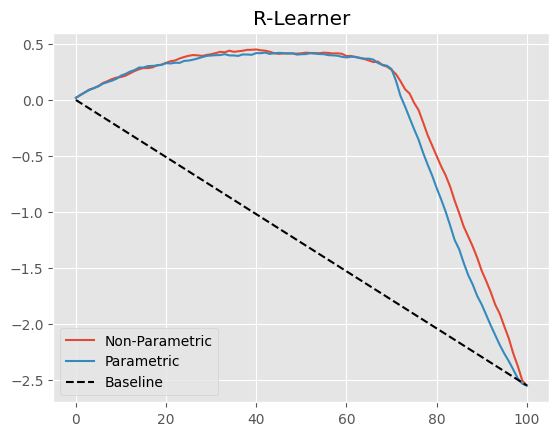

In [24]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

Not a huge improvement here, but it's something. Plus, not having to specify the functional form of the treatment function is already a huge benefit. 


### What is Non-Parametric About?
 
Before we move on, I just wanted to highlight a common misconception. When we think about using a non-parametric Double-ML model to estimate the CATE, it looks like we will get a nonlinear treatment effect. For instance, let's assume a very simple `data generating process (DGP)` where discont affects sales non-linearly, but through a square root function. 
 
$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$
 
The treatment effect is given by the derivative of this Sales function with respect to the treatment.
 
$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$
 
As we can see, the treatment effect is **not** linear. It actually gets weaker as the treatment increases. This makes a lot of sense for this DGP. At first, a little bit of discount increases sales by a lot. But, as we give too much discount, an extra unit of discount will affect sales less and less, because people won't want to buy to infinity. Hence, the discount is only effective up until they point they get satiated. 
 
The question then is, can the non-parametric ML capture this saturating behavior in the treatment effect? Can it extrapolate from a small discount level that, if the discount were higher, the treatment effect would be lower? The answer is... sort of. To better understand that, let's generate data like in the above DGP.

In [25]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

If we plot this DGP, we can see the square root relationship between these variables.

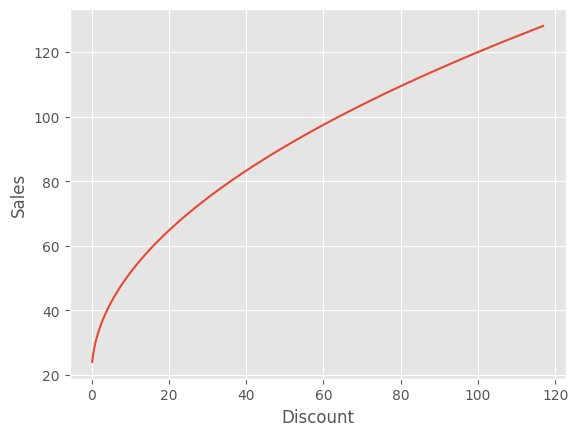

In [26]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");

Now, let's apply the Non-Parametric Double/Debias ML to this data. 

In [27]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2 
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 0
[LightGBM] [Info] Start training from score 23.675958
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

With the above model, we can get the CATE estimate. The issue here is that the CATE is not linear. As the treatment increases, the CATE should decrease. 

The question we are trying to answer is __if the non-parametric model can capture that non linearity__. 
 
To answer that properly, let's remember what is the underlying assumption that the Double/Debiased ML makes about the data generating process. These assumptions can be seen in the equation we've laid down before.
 
$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
In words, it says that the residualized outcome is equal to the residualized treatment multiplied by the conditional treatment effect. This mean that the **treatment impacts the outcome linearly**. There is no non-linearity here. The above model says that the outcome will increase by a fixed amount $\tau(X_i) $ if we increase the treatment from 1 to 10 or from 100 to 110. It's a simple multiplication. 
 
So, does this mean that the non-parametric model can't capture the non-linearity of the treatment effect? Again, not really... 

Rather, what is happening is that Double/ML **finds the locally linear approximation to the non-linear CATE**. In other words, it finds the derivative of the outcome with respect to the treatment at that treatment level or around the treatment. This is equivalent to finding the slopes of the lines that are tangential to the outcome function at the treatment point.
 
![img](./data/img/debiased-ml/linear-aprox.png)
 
This mean that, yes, Non-Parametric Double-ML will figure out that the treatment effect will be smaller as we increase the treatment. But, no, it won't find the non-linear treatment effect, but rather the local linear treatment effect. We can even plot those linear approximations against the ground true non-linear causal effect and indeed, they are good approximations. 

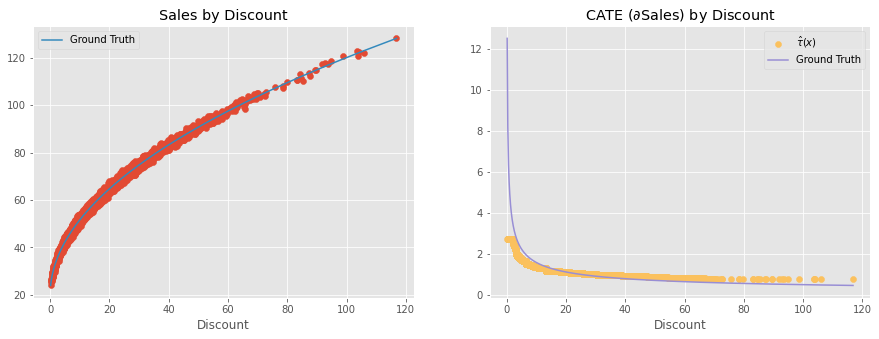

In [22]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

This might sound like technicalities, but it has very practical consequences. For example, let's say you find a treatment effect of 2 for a customer in the example above, meaning that if you increase the discount by 1 unit, your sales to that customer will increase by 2 units. You might look at that and think: "Great! I'll give a lot of discounts to this unit! After all, for every 1 unit in discount, I'll get 2 in sales". However, that's the wrong conclusion. The treatment effect is 2 only at that discount level. As soon as you increase the discount, the effect will fall. For example, say this hypothetical customer got only 5 in discount, which is why her treatment effect is so high. Say you see that huge treatment effect and use it to justify giving 20 in discount to that customer. But as you do so, the effect might go from 2 to something like 0.5. And a 20 discount that made sense at a treatment effect of 2 might no longer be profitable at a treatment effect of 0.5.
 
This means you have to be extra careful when extrapolating a nonlinear treatment effect to a new treatment level. If you are not, you might end up making very unprofitable decisions. Another way to put is is that, when treatment effect is not linear, even non-parametric Double/Debiased-ML will **struggle to make counterfactuals outcome predictions**. It will try to linearly extrapolate the treatment effect (TE) from a low treatment level to a high treatment level or the other way around. And, due to the non linearity, that extrapolation will likely be off. 
 
To solve that, there is a final idea. Keep in mind that this idea is much less scientific than the things we've seen before. It boils down to using a `S-learner` after applying the orthogonalization procedure, but I'm getting ahead of myself. Let's look at that next. 

![img](./data/img/debiased-ml/non-sci.png)

## Non-Scientific Double/Debiased ML

The final idea we will try is a fundamental shift in mentality. We will no longer try to estimate the linear approximation to the CATE. Instead, we will make counterfactual predictions.
 
![img](./data/img/debiased-ml/cf-pred.png)
 
The CATE is the slope of the outcome function at the data point. It is how much we expect the outcome to change if we increase the treatment by a very small amount. More technically, it's the derivative at the point. Counterfactual predictions, on the other hand, are an attempt to recreate the entire outcome curve from a single datapoint. We will predict what the outcome would be if the treatment were at some other level than the one it currently takes, hence the counterfactual. 
 
If we manage to do so, we will be able to simulate different treatments for a unit and predict how it would respond under those different treatment levels. This is very risky business, because we will be extrapolating an entire curve from a single point. Also, although I've used this technique in practice a lot, I've never found any scientific article showing how or why it works. That's why I call it the Non-Scientific Double-ML. Simply put: beware!
 
Here is how this will go down. First, let's start with the traditional Double/Debiased-ML formulation, where we have the residualized version of the treatment and outcome.
 
$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$
 
Now, I'll move the treatment inside the treatment effect function. This allows the treatment effect to be non linear, that is to change with the treatment itself. 
 
$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$
 
This is dangerous business, because I have no idea how this treatment functions. For all we know, it could be some weird non-linear function. But, fortunately, we know how to estimate weird functions with Machine Learning. So, that's what we will do. Simply speaking, we will fit a ML model to predict the residualised outcome $\tilde{Y}$ from the residualized treatment $\tilde{T}$ together with the features $X$. The residualisation is important to remove bias and noise so that this final ML can focus on learning only the treatment effect and how the covariates $X$ impact that treatment effect. 
 
Then, once we have this model, we will make 2 step counterfactual predictions. First we will have to make a prediction for the treatment in order to get $\tilde{T}$, then, we will feed that prediction, along with the features, in our final model $\hat{\tau}(X_i, \tilde{T}_i)$.
 
Since we will have to make $\tilde{T}$, we first need to implement our own version of the `cross_prediction` function. This function will return not only the cross prediction, but also the models used to make those predictions.

In [23]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


Now that we have our own cross prediction function that also gives us the models, we can proceed with the orthogonalisation step.

In [24]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

After the orthogonalisation, we will throw $\tilde{T}$ along with $X$ to a ML model that tries to precit $\tilde{Y}$. I'm using a LGBM model here, but you can pick any ML model. One cool thing about LGBM is that I can set monotonic constraints to it. Knowing what we know about prices, sales should decrease as price increases. We can take that into account and constrain our LGBM model **to not increase** it's predictions as prices increase. 

In [25]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

Now is where things get a little weird. If we think about it, this final ML model is estimating the following $\tau$ treatment function
 
$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$
 
but there isn't a clear way to extract the treatment effect from this function. So,  rather than extracting a treatment effect, we will input the counterfactual predictions, just like I've shown in the previous image. We will simulate different price levels for each unit and use our Double-ML model to predict what would be the sales we would see under those different price levels. 

To achieve that, we will 1) cross join the test set with a price table that contains all simulated prices. The end result will be as follows

In [26]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


Notice that we are showing only the day in index 1, so only a single unit. On that day (unit), the actual or factual price or treatment was 7. But we've simulated different counterfactual treatments, from 3 to 10. Now, we will feed all those counterfactual prices to our causal model, which will make counterfactual sales predictions based on those simulated prices.
 
Since our model has the following format
 
$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$
 
Before making the counterfactual predictions, we need to get $\tilde{T}_i$, that is, the price residuals. We will get those residuals by first, making predictions will all our treatment models (remember that we've used a 5 fold cross prediction in the training step), then we will average the predictions from the five models into a single prediction and finally subtract the counterfactual price we've generated earlier from the predicted price using this ensemble of models.

In [27]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,16.093630
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-10.939867
6,0,25.8,1,0.3,7,230,8.250,-21.655858
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


As you can see, we now have a sales prediction for every simulated price. The lower the price, the higher the sales. One interesting thing is that these predictions are off in their level. For instance, they go from about 24 to about -24. That's because the model is predicting the residualized outcome, which is roughly mean zero. This is fine if all you want is to get the slope of the sales curve, which is the price treatment effect. Also, if you want to fix the prediction levels, all you have to do is add the predictions from the denoising model $M_y$. 

In [28]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + 
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,254.208352
1,0,25.8,1,0.3,7,230,3.875,250.768336
2,0,25.8,1,0.3,7,230,4.750,245.999133
3,0,25.8,1,0.3,7,230,5.625,236.180099
4,0,25.8,1,0.3,7,230,6.500,228.280878
5,0,25.8,1,0.3,7,230,7.375,218.965636
6,0,25.8,1,0.3,7,230,8.250,208.249645
7,0,25.8,1,0.3,7,230,9.125,204.586329
8,0,25.8,1,0.3,7,230,10.000,204.586329


We can also plot the unit level sales curve. Let's sample ten units and see how they would behave under different prices.

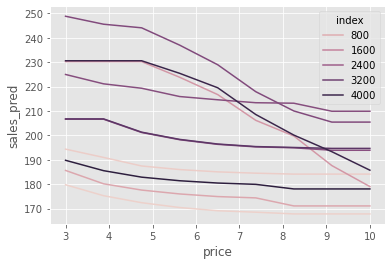

In [29]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

It is interesting to see that some units are very sensitive to price increases. In some cases, we expect sales to drop from 250 to almost 200 as we increase the price from 3 to 10. On the other hand, some units are very inelastic to price: as we increase prices from 3 to 10, we expect the sales to go from about 195 to about 185. 
 
It's hard to see these differences in price sensitivity, so what I like to do is to make all the curves start from the same point (the average sales here). This will make it easier to see that some units have a sharp drop in sales as we increase prices, while others not so much.

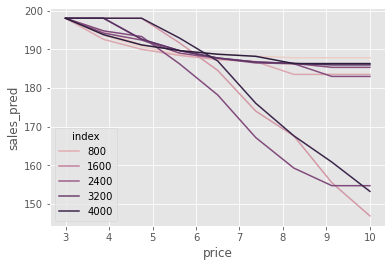

In [30]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### More Econometrics May be Needed!
 
![img](./data/img/debiased-ml/more-metrics.png)
 
I want to end this section on the non-scientific Double-ML with a word of caution. I didn't call this approach non scientific for nothing. It is sort of a hack to get non linear counterfactual predictions. And since it's a hack, I feel it is worth talking about its potential downsides.
 
First and foremost, it has the same problems all ML techniques have when applied naively to causal inference: bias. Since the final model is a regularized ML model, this regularization can bias the causal estimate to zero. 
 
The second problem has to do with the ML algorithm you choose. Here, we choose boosted trees. Trees are not very good at making smooth predictions. As a consequence, we can have discontinuities in the prediction curve. You can see that in the plots above: a stepwise behavior here and there. Also, trees are not very good at extrapolating, so this model might output weird predictions for prices never seen before. 

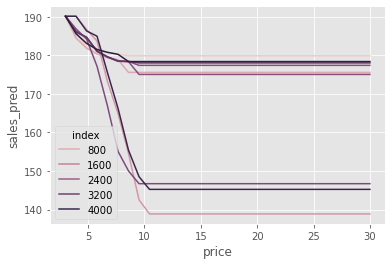

In [31]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

All this to say that this approach is highly dependent on the final ML model. If you regularize it too much, you will bias your causal estimates to zero. If you use this or that ML algorithm, you carry all its limitations to your final counterfactual predictions. Still, if you think this approach is worth a try, by all means give it a shot! Just don't forget the downsides I've outlined here.

## Key Ideas
 
Double/Debiased/Orthogonal ML is a way to delegate estimating nuisance parameters which allows us to focus our attention on the causal parameter of interest. It first employes a two step orthogonalisation procedure:
 
1. Fit a model $M_t(X)$ to predict the treatment from the covariates X and get out of fold residuals $\tilde{t} = t - M_t(X)$. We called this the debiasing model because the residuals $\tilde{t}$ are, by definition, orthogonal to the features used to construct it.
 
2. Fit a model $M_y(X)$ to predict the outcome from the covariates X and get out of fold residuals $\tilde{y} = y - M_y(X)$. We called this the denoising model because the residual $\tilde{y}$ can be seen as a version of the outcome where all the variance from the features got explained away.
 
Once we have those residuals, provided there are no unmeasured confounders, we can regress $\tilde{y}$ on $\tilde{t}$ for a linear approximation to the ATE. We can also interact $\tilde{t}$ with the covariates to estimate the CATE or use a weighting trick to allow for any generic ML model as our final CATE model. 
 
![img](./data/img/debiased-ml/diagram.png) 
 
Finally, I've argued that the orthogonalization steps is a general tool to facilitate causal learning. In that spirit, we've tried to feed the treatment and outcome residuals to a S-learner style ML algorithm. With that, we managed to get counterfactual predictions from simulated treatments. Indeed orthogonal ML serves as a pre-processing step in many causal inference applications.

 
## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
To write this chapter, I've relied on Chernozhukov et al (2016), *Double/Debiased Machine Learning for Treatment and Causal Parameters*, D. Foster and V. Syrgkanis (2019) *Orthogonal Statistical Learning* and on the *econml* library documentation page. Orthogonal ML has gotten a lot of attention lately, so there are many other references on the subject. To name a few, Nie and Wager (Draft, 2020) have a nice discussion on the R-loss, Athey et al (2019) talk about it in the context of causal decision trees and there are many subsequent papers by Chernozhukov, which develop the subject further. 
 
I also stole an image from [Pedro Sant'Anna's slides](https://pedrohcgs.github.io/files/Callaway_SantAnna_2020_slides.pdf).

 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).